# Pendulum with Structured LNN and Control
- We know the data is angle and use it as advantage

## TODO:

- Plot Mass Matrix
- Plot Potential
- Understand the control

In [1]:
import numpy as np
import torch

import sys
import time
sys.path.append("../../")

## Train Model

In [2]:
# hparams
num_sample = 10000
batch_size = 128
portion = 0.5

learning_rate = 3e-4
min_delta = 0
patience = 50

time_horizon = 5
solver = 'rk4'

model_name = 'latent_vae.pt'
# Check Model params in Model section

### Set Seed Here

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Load the data set
- init_condition: list of tuple

 [(x0, p0, t0, t1, steps)]

In [4]:
from gym_env import PendulumCustomEnv
from data import Gym_DataModule_rng

In [5]:
env = PendulumCustomEnv(full_phase=True)
low = np.array([-2])
high = -low

# env, time step, traj, control
dataModule = Gym_DataModule_rng(env,
                                num_sample,
                         
                                low=low,
                                high=high,
                                no_act_portion=portion,
                                time_horizon=time_horizon,
                                batch_size=batch_size,
                                data_dir='../../data/dataset',
                                use_img=True)

dataModule.setup()

In [6]:
print(dataModule.dataset.tensors[0].shape)  # (bs, time, [cos q, sin, q, dq])
print(dataModule.dataset.tensors[1].shape)  # (bs, time, [control])
print(dataModule.dataset.tensors[2].shape)  # (bs, time, [time])
print(dataModule.dataset.tensors[3].shape)  # (bs, time, [th, dth, ddth])
print(dataModule.dataset.tensors[4].shape)  # (bs, time, images)

torch.Size([10000, 5, 3])
torch.Size([10000, 5, 1])
torch.Size([10000, 5, 1])
torch.Size([10000, 5, 3])
torch.Size([10000, 5, 28, 28, 2])


### Define Model

In [7]:
from torchdyn.models import NeuralODE

from module.LNNODE_latent import LNNODE_latent
from nn import MLP, PSD, MatrixNet

In [8]:
massMatrixNet = PSD([2, 64, 64, 1], activation='sigmoid')
potentialNet = MLP([2, 64, 64, 1], activation='sigmoid')
controlNet = MatrixNet([2, 64, 64, 1], control_dim=1, activation='relu')

lagFunc = LNNODE_latent(num_angle=1, 
                        massMatrixNet=massMatrixNet,
                        potentialNet=potentialNet,
                        controlNet=controlNet)

lagODE = NeuralODE(lagFunc, sensitivity='adjoint', solver=solver).to(device)

In [9]:
torch.save(lagODE, 'models/before_{}'.format(model_name))

### Define Pytorch lightning trainer

In [10]:
import torch.nn.functional as F

import pytorch_lightning as pl

from pytorch_lightning.callbacks import EarlyStopping

In [11]:
class Learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss

        self.kl_coeff = 0.1
        self.log_scale = torch.nn.Parameter(torch.Tensor([0.0]))  # For reconstruction

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)

        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)

        self.log('val_loss', loss)
        self.logger.experiment.add_scalars("loss", {"val": loss}, self.current_epoch)
        return loss

    def reparametrize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        z = torch.randn(size=(mu.size(0), mu.size(1)))
        z = z.type_as(mu)  # Setting z to be .cuda when using GPU training
        return mu + sigma * z

    def step(self, batch, batch_idx):
        _, u, t, info, imgs = batch
        t_span = t[0, :, 0]
        bs = imgs.shape[0]
        time_horizon = t.shape[1]

        imgs_reshaped = imgs.permute(0, 1, 4, 2, 3)
        
        kl_loss = 0
        recon_loss = 0
        
        for t in range(time_horizon):
            enc = self.model.defunc.m.encoder(imgs_reshaped[:, t, :])
            mu = self.model.defunc.m.fc_mu(enc)
            log_var = self.model.defunc.m.fc_var(enc)

            kl_loss += (-0.5 * (1 + log_var - mu ** 2 - torch.exp(log_var)).sum(dim=1)).mean(dim=0)
            hidden = self.reparametrize(mu, log_var)

            imgs_recon = self.model.defunc.m.decoder(mu)

            recon_loss = self.loss_func(imgs_recon, imgs_reshaped[:, t, :])

        loss = recon_loss * 1024 + kl_loss

        logs = {
            "recon_loss": recon_loss,
            "kl": kl_loss,
            "loss": loss,
        }
        return loss, logs

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

In [12]:
learn = Learner(lagODE)

early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=min_delta, patience=patience)
trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=500, max_epochs=5000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


### Train

In [13]:
start_time = time.time()

In [14]:
trainer.fit(learn, dataModule)


  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 224 K 
------------------------------------
224 K     Trainable params
0         Non-trainable params
224 K     Total params
0.897     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to impro

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 4.767
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.601 >= min_delta = 0. New best score: 4.166


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0. New best score: 4.126


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0. New best score: 4.115


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0. New best score: 4.110


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0. New best score: 4.106


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0. New best score: 4.096


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0. New best score: 4.057


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.049 >= min_delta = 0. New best score: 4.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0. New best score: 3.957


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.069 >= min_delta = 0. New best score: 3.889


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.074 >= min_delta = 0. New best score: 3.814


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.138 >= min_delta = 0. New best score: 3.677


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.130 >= min_delta = 0. New best score: 3.547


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.119 >= min_delta = 0. New best score: 3.428


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.127 >= min_delta = 0. New best score: 3.301


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.104 >= min_delta = 0. New best score: 3.197


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.084 >= min_delta = 0. New best score: 3.113


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.080 >= min_delta = 0. New best score: 3.033


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.057 >= min_delta = 0. New best score: 2.976


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.071 >= min_delta = 0. New best score: 2.906


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0. New best score: 2.854


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.073 >= min_delta = 0. New best score: 2.781


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.093 >= min_delta = 0. New best score: 2.688


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.054 >= min_delta = 0. New best score: 2.634


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0. New best score: 2.599


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0. New best score: 2.546


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0. New best score: 2.519


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0. New best score: 2.499


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0. New best score: 2.462


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0. New best score: 2.440


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0. New best score: 2.422
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


In [15]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 492.6032841205597 seconds ---


### Save Model
- Pytorch Lightning model check point is buggy
- Use Pytorch save and load method instead

In [16]:
torch.save(lagODE, 'models/{}'.format(model_name))

## Model Analysis

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

### Load Model

In [18]:
test_model = torch.load('models/{}'.format(model_name))
test_model.eval()

test_model = test_model

### Generate trajectory with Gym Env

In [19]:
# define testing time stamp
dt = 0.05
full = 100
t_span = torch.linspace(dt, dt*full, full)

In [20]:
import cv2
def preproc_pend(img):
    gray = cv2.cvtColor(img[220: 780, 220: 780, :], cv2.COLOR_BGR2GRAY)  # Grey Scale
    img = cv2.resize(gray, [28, 28])  # Rescale image
    img[img == 255] = 0  # Black background (0 seems better for training)
    output = img / 255
    return output

In [21]:
# Generate Trajectory
env.seed(0)
np.random.seed(0)

env = PendulumCustomEnv()
obs = []
infos = []
images = []

# control = 2
# controls = np.random.randint(-2, 2 + 1, full+1)
split = 20
controls = np.random.randint(-2, 2 + 1, int(full / split))
controls = np.repeat(controls, split)
controls = np.zeros_like(controls)

# obs0, _ = env.reset(np.array([3., 1.]))
obs0, _ = env.reset(np.array([np.pi / 2, 0.]))

prev_obs = obs0
prev_img = env.render('rgb_array')

for i in range(full):
    obs.append(prev_obs)
    images.append(preproc_pend(prev_img))
    
    next_obs, reward, done, info = env.step(controls[i])
    next_img = env.render('rgb_array')
    
    infos.append(np.array([info['th'], info['dth'], info['ddth']]))
    
    prev_obs = next_obs
    prev_img = next_img

obs = torch.tensor(obs)
infos = torch.tensor(infos)
imgs = torch.tensor(images)
controls = torch.Tensor(controls).view(-1, 1)
env.close()

### Generate Prediction

In [22]:
P = imgs[1:, :, :]
dP = imgs[1:, :, :] -imgs[: -1, :, :]
P_dP = torch.stack([P, dP], dim=3)

In [23]:
dataModule.dataset.tensors[4].shape

torch.Size([10000, 5, 28, 28, 2])

In [24]:
# z = test_model.defunc.m.encoder(P_dP.reshape(1, full-1, -1).float())
data = dataModule.dataset.tensors[4].reshape(10000 * 5, 2, 28, 28).float()
z = test_model.defunc.m.encoder(data)
z_mu = test_model.defunc.m.fc_mu(z)
z_std = torch.exp(test_model.defunc.m.fc_var(z))

In [25]:
plt.plot(t_span[:full-1].detach().numpy(), z[0, :, 0].detach().numpy())
# plt.ylim(-4, 4)

IndexError: too many indices for tensor of dimension 2

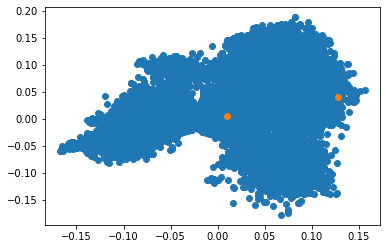

In [26]:
t = 50000
plt.scatter(z_mu[:t, 0].detach().numpy(), z_mu[:t, 1].detach().numpy())
plt.scatter(z_mu[[3, 5], 0].detach().numpy(), z_mu[[3, 5], 1].detach().numpy())
# plt.xlim(-0.1, 0.1)

In [ ]:
from utils import traj_pred

# Generate prediction

q_dq_u = torch.stack([torch.cos(z[0, :, 0]), torch.cos(z[0, :, 0]), z[0, :, 1], controls[1:, 0]], dim=1)
q_dq = torch.stack([torch.cos(z[0, :, 0]), torch.cos(z[0, :, 0]), z[0, :, 1]], dim=1)
est_grad = test_model.defunc(0, q_dq_u.float())
est_z = traj_pred(0.05, test_model, q_dq[0, :].detach().numpy(), controls)

In [ ]:
plt.plot(est_z.y[1, :])

In [ ]:
est_z2 = torch.tensor(est_z.y.T)

In [ ]:
angle = torch.atan(est_z2[:, 1] / est_z2[:, 0]) + np.pi/2

In [ ]:
est_z2 = torch.stack([angle, est_z2[:, 2]], dim=1)

In [ ]:
plt.scatter(est_z2[:200, 0], est_z2[:200, 1])

In [ ]:
z.shape

In [ ]:
# recon_img = test_model.defunc.m.decoder(est_z2.float())
test_mu = test_model.defunc.m.fc_mu(z)
test_var = test_model.defunc.m.fc_var(z)
recon_img = test_model.defunc.m.decoder(test_mu)

In [ ]:
recon_img = recon_img.reshape(50000, 28, 28, 2)

In [ ]:
torch.unsqueeze(P_dP[0, :, :, :].permute(2, 0, 1), 0).shape

tensor([[-0.1539,  0.0010]], grad_fn=<AddmmBackward>) tensor([[0.0007, 0.0012]], grad_fn=<AddmmBackward>)
tensor([[ 0.0340, -0.0716]], grad_fn=<AddmmBackward>) tensor([[-0.0031, -0.0008]], grad_fn=<AddmmBackward>)


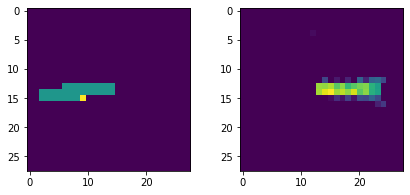

In [29]:
i = 25
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(P_dP[i, :, :,0].detach().numpy())

z_test1 = test_model.defunc.m.encoder(torch.unsqueeze(P_dP[0, :, :, :].permute(2, 0, 1), 0).float())
z_test2 = test_model.defunc.m.encoder(torch.unsqueeze(P_dP[25, :, :, :].permute(2, 0, 1), 0).float())

mu1 = test_model.defunc.m.fc_mu(z_test1)
log_var1 = test_model.defunc.m.fc_var(z_test1)
                                      
mu2 = test_model.defunc.m.fc_mu(z_test2)
log_var2 = test_model.defunc.m.fc_var(z_test2)

print(mu1, log_var1)
print(mu2, log_var2)

mu_test = (mu1 * 1 + mu2 * 4) /5
out = test_model.defunc.m.decoder(mu1).permute(0, 2, 3, 1)

ax2.imshow(out.detach().numpy()[0, :, :, 0])

In [ ]:
from scipy.integrate import solve_ivp

def dummy(t, y):
    idx = int(torch.tensor(t) / dt)
    dx1 = np.multiply(-y[1], y[2])
    dx2 = np.multiply(y[0], y[2])
    ddq = -10 * y[0] + controls[idx-1] / 2.
    return [dx1, dx2, ddq]

sol = solve_ivp(dummy, [dt, dt*full], obs0, method='Radau', t_eval=t_span.detach().numpy())

In [ ]:
print(sol.y.shape)
print(obs0)
# sol.t

### Check gradient

In [ ]:
fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

start = 0
end = 500

# Check ddq_est
ax1.plot(t_span.detach().numpy()[start:end], infos[start:end, 2],'x-', alpha=0.5)  # Ground truth
ax1.plot(t_span.detach().numpy()[start:end], est_grad[start:end, 2].detach().numpy(), '--')  # LNN

# check dq_est
ax2.plot(t_span.detach().numpy()[start:end], infos[start:end, 1],'-', alpha=0.5)
ax2.plot(t_span.detach().numpy()[start:end], est.y[2, start:end], '--')  # LNN
# ax2.plot(sol.t[start:end], sol.y[2, start:end])

# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start:end],'x')
# None

### Check trajectory

In [ ]:
# Check trajectory
start = 0
end = 100

fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Plot cos q = x
ax1.plot(t_span.detach().numpy()[start:end], obs[start:end, 0].detach().numpy(), alpha=0.5)
ax1.plot(t_span.detach().numpy()[start:end], est.y[0, start:end], '--')
ax1.plot(sol.t[start:end], sol.y[0, start:end])

# Plot sin q = y
ax2.plot(t_span.detach().numpy()[start:end], obs[start:end, 1].detach().numpy(), alpha=0.5)
ax2.plot(t_span.detach().numpy()[start:end], est.y[1, start:end], '--')
ax2.plot(sol.t[start:end], sol.y[1, start:end])


# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start+1:end+1])
# None
None

### Plot Phase Space Trajectory

In [ ]:
length = 100
# Plot Phase Space traj
th = torch.atan(obs[:length, 1] / obs[:length, 0])
thdot = obs[:length, 2]

est_th = torch.atan(torch.tensor(est.y[1, :length] / est.y[0, :length]))
est_thdot = est.y[2, :length]

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(th, thdot)
plt.scatter(est_th, est_thdot)

ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Phase Diagram")
None

### Plot Mass Matrix

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

M_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    M_est[i] = test_model.defunc.m.massMatrixNet(q.view(1, -1)).detach().cpu()[0, 0, 0]

    
M_true = torch.ones(M_est.shape)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), M_est, '--', label='M_est')
ax.plot(x.detach().numpy(), M_true, label='M_true', alpha=0.5)

ax.legend()
# ax.set_ylim([0, 1.1])
ax.set_xlabel("q")
ax.set_ylabel("M(q)")
ax.set_title("Mass Matrix")
None

### Plot Potential

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

V_true = 1. * 10 * torch.sin(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    V_est[i] = test_model.defunc.m.potentialNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='V_est')
ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("V(q)")
ax.set_title("Potential")
None

### Plot Control

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
x1, x2 = torch.meshgrid(x, x)  # (cos q, sin q)

Control = 1. * 10 * torch.ones_like(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    V_est[i] = test_model.defunc.m.controlNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='Control_est')
# ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("g(q)")
ax.set_title("Control")
None

## Conclusion